In [6]:
import os
from glob import glob
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
import umap
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
import function.utils as ut

In [7]:
def prepare_data(M, label, trial=None):
    '''
    Parameters
    ----------
    M : numpy 3d array, shape (ntrial, ybin, ncell)
        Spatial tuning of a given mouse with all trials stacked along axis=0
        Note that axes are permuted compared to tuning to avoid repeated transpose.
    label : numpy 1d array, shape (ntrial,)
        Context label of each trial.
    trial : numpy 1d array
        Indices of selected trials

    Returns
    -------
    X : numpy 2d array, shape (n_samples, ncell*ybin)
    y : numpy 1d array, shape (n_samples,) where n_samples = ntrial
    '''
    ntrial, ybin, ncell = M.shape
    
    if trial is None:  # Take all trials
        trial = np.arange(ntrial)
    elif isinstance(trial, int):
        trial = [trial]
        
    X = np.vstack([M[r].ravel() for r in trial])  # Stack ybin as features
    y = label[trial]
    
    return X, y

def shuffle_label(label, seed=0):
    '''Shuffle the context labels.
    '''
    rng = np.random.default_rng(seed)
    return rng.permutation(label)

def decode_context_cv(M, label, nfold=10):
    
    ntrial, ybin, ncell = M.shape
    accuracy = []
    coefficient = []
    cv = StratifiedKFold(n_splits=nfold, shuffle=False)
    
    for train_set, test_set in cv.split(np.zeros((ntrial,1)), y=label):  # X does not matter here 
    
        X_train, y_train = prepare_data(M, label, trial=train_set)
        X_test, y_test = prepare_data(M, label, trial=test_set)
        
        ## Linear support-vector classifier
        clf = SVC(kernel='linear')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        for r in range(len(y_test)):
            accuracy.append(y_pred[r]==y_test[r])
            
        coefficient.append(np.reshape(clf.coef_, (ybin, ncell)))
    
    return np.array(accuracy), np.stack(coefficient).mean(axis=0).T  # (ncell, ybin)

## Load data

In [18]:
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}
p = 2
exps = ['Enriched','Dissimilar','Similar']
datapath = alldata[exps[p]][3]
day = 1  # Recording days, None for all days
min_rate = 0/60  # 1/60  # Minimum transient rate for active cells
ybin = 20  # Number of spatial bins
ysigma = 0  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

In [19]:
data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate, verbose=True)
with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # Dataset dependent
        
tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                           spike=False, transient=True)
    
M = np.concatenate(tuning, axis=2)  # (ncell, ybin, ntrial)
M = np.transpose(M, (2,1,0))  # (ntrial, ybin, ncell)
label = np.hstack([np.repeat(ctx[k], tuning[k].shape[2])
                   for k in range(len(tuning))])  # (ntrial,)

------------------------------------
Total cells: 70
Active cells: 65
Proportion of active cells 92.86 %
Active in both 71.43 %
Active exclusively in Fam 14.29 %
Active exclusively in Nov 7.14 %
------------------------------------


In [20]:
print(M.shape)
print(label.shape)

(40, 20, 65)
(40,)


## Visualize with dimensionality reduction

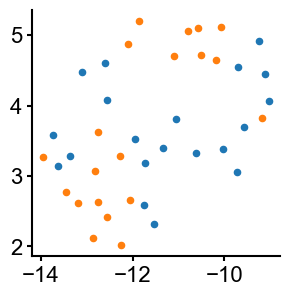

In [21]:
ratio = 0.2

ntrial, ybin, ncell = M.shape
X = np.vstack([M[r].ravel() for r in range(ntrial)])  # Stack ybin as features
n_neighbors = int(ratio * X.shape[0])

reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1,
                    metric='cosine', random_state=0)
X_ = reducer.fit_transform(X)

colors = ['C0','C1']
fig, ax = plt.subplots(figsize=(3.2,3.2))
for c in range(2):
    ax.scatter(X_[label==c,0], X_[label==c,1], c=colors[c], s=20, zorder=100)

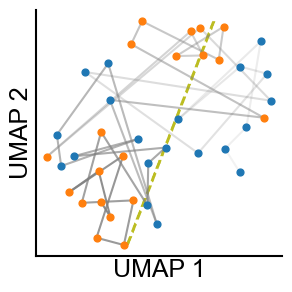

In [22]:
n_samples = X.shape[0]
alphas = np.linspace(0.1,0.9,n_samples-1)
xmin, xmax = X_[:,0].min(), X_[:,0].max()
ymin, ymax = X_[:,1].min(), X_[:,1].max()
dx = xmax - xmin
dy = ymax - ymin

clf = SVC(kernel='linear')
clf.fit(X_, label)
xx, yy = np.meshgrid(np.linspace(xmin,xmax,400),
                     np.linspace(ymin,ymax,400))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
    
fig, ax = plt.subplots(figsize=(3.2,3.2))
ax.contour(xx, yy, Z, [0.5], colors='tab:olive', linewidths=2, linestyles='--', zorder=-1)
for i in range(n_samples-1):
    seg = slice(i,i+2)
    ax.plot(X_[seg,0], X_[seg,1], c='gray', alpha=alphas[i])
for c in range(2):
    ax.scatter(X_[label==c,0], X_[label==c,1], c=colors[c], s=24, zorder=n_samples)
ax.set(xlim=[xmin-dx/20, xmax+dx/20], ylim=[ymin-dy/20, ymax+dy/20],
       xlabel='UMAP 1', ylabel='UMAP 2')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
fig.tight_layout()
fig.savefig('Projection similar4.svg')

## Decode context

In [60]:
def decode_context(datapath, day=1, min_rate=1/60, ybin=80, ysigma=1, nfold=10, seed=0):
    
    ## Load data
    data, cells, days, ctx = get_data_bis(
        datapath, day=day, min_rate=min_rate, verbose=False)
    
    with h5py.File(datapath, 'r') as f:
        yrange = f['params/yrange'][()]  # Dataset dependent
    
    ## Prepare data (spatial tuning)
    tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                               spike=False, transient=True)
    
    M = np.concatenate(tuning, axis=2)  # (ncell, ybin, ntrial)
    M = np.transpose(M, (2,1,0))  # (ntrial, ybin, ncell)
    label = np.hstack([np.repeat(ctx[k], tuning[k].shape[2])
                       for k in range(len(tuning))])  # (ntrial,)
    
    accuracy = [[] for _ in range(2)]  # original, shuffle context
    
    accuracy[0], coefficient = decode_context_cv(M, label, nfold=nfold)
    print('Mean accuracy (original) %.4g' % np.mean(accuracy[0]))
    
    ## Apply on shuffled data
    label2 = shuffle_label(label, seed=seed)
    accuracy[1], _ = decode_context_cv(M, label2, nfold=nfold)
    print('Mean accuracy (shuffled) %.4g' % np.mean(accuracy[1]))
    
    return np.vstack(accuracy), coefficient

In [75]:
accuracy, coefficient = decode_context(
    datapath, day=day, min_rate=min_rate, ybin=ybin, ysigma=ysigma, nfold=10, seed=0)


Mean accuracy (original) 0.75
Mean accuracy (shuffled) 0.55


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

0_Original vs. 0_Shuffled: Mann-Whitney-Wilcoxon test greater, P_val:3.161e-02 U_stat=9.600e+02


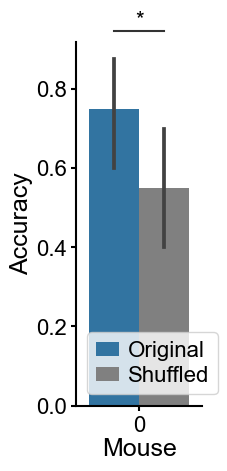

In [76]:
ut.compare_grouped([accuracy], varnames=['Mouse','Data','Accuracy'],
                   varvalues=[None,['Original','Shuffled'],None], kind='bar',
                   palette=['C0','gray'], test='Mann-Whitney-gt');